# Methodology version 2!

A methodology that explores to design ortfolios based on identifying non-linear relationships between stocks


In [75]:
import copy
import datetime

import pandas as pd
import numpy as np
 
import src.utils.returns_preprocessing as preproc
import src.pca.eigen_portfolios_functions as eg_functions

import src.autoencoders.autoencoder_market_projection as ae_market
import src.autoencoders.autoencoder_portfolio_calibration as ae_portfolio_cal

import src.utils.portfolio_utils as portfolio_utils
import src.pca.rmf_filtering as rmf_filter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading the data

in this stage, I must collect other actions!!

In [61]:
# load from persisted data
df_prices = pd.read_csv('./data/ibovespa_q1_2023_prices.csv')
df_prices.index = df_prices['Unnamed: 0']
df_prices = df_prices.drop('Unnamed: 0', axis = 1)
df_prices.head()

,^BVSP,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2020-01-02,118573.0,19.200001,32.580002,65.180000,63.910000,NaN,58.799999,15.036666,53.799999,26.626596,...,15.770000,23.049999,25.600000,9.70,54.330002,30.740000,11.73,48.240002,17.620001,46.750000
2020-01-03,117707.0,18.930000,32.580002,64.300003,63.000000,NaN,56.759998,14.603333,53.709999,26.198347,...,15.800000,23.540001,25.299999,9.60,53.930000,30.559999,11.48,48.799999,17.395000,45.770000
2020-01-06,116878.0,19.020000,32.070000,63.900002,62.610001,NaN,55.000000,14.463333,53.000000,26.048084,...,15.780000,23.003332,24.750000,9.42,53.610001,29.030001,11.48,48.330002,17.440001,46.650002
2020-01-07,116662.0,19.059999,32.799999,63.740002,62.900002,NaN,56.820000,14.930000,52.599998,25.604809,...,15.950000,23.100000,25.299999,9.51,54.000000,28.990000,11.65,49.400002,17.575001,45.779999
2020-01-08,116247.0,18.969999,33.160000,64.589996,62.000000,NaN,56.919998,14.890000,52.119999,25.214125,...,16.120001,22.790001,25.100000,9.39,54.009998,28.850000,11.60,49.900002,16.910000,45.509998


In [62]:
#columns with nan
#df_prices.columns[df_prices.isna().any()].tolist()


df_prices = df_prices.tail(253).dropna()
df_prices.head()
### Temporary I select the a track of 252 days as there are not null values in this

,^BVSP,ABEV3.SA,ALPA4.SA,AMER3.SA,ARZZ3.SA,ASAI3.SA,AZUL4.SA,B3SA3.SA,BBAS3.SA,BBDC3.SA,...,TIMS3.SA,TOTS3.SA,UGPA3.SA,USIM5.SA,VALE3.SA,VBBR3.SA,VIIA3.SA,VIVT3.SA,WEGE3.SA,YDUQ3.SA
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2022-02-16,115181.0,15.08,27.090000,35.439999,85.400002,13.05,29.290001,14.59,35.330002,16.372726,...,13.82,30.450001,15.80,15.49,89.500000,24.450001,4.15,49.290001,31.299999,22.350000
2022-02-17,113528.0,14.85,26.799999,34.279999,83.769997,13.25,28.780001,14.20,35.330002,16.209089,...,13.78,32.220001,15.51,14.86,85.650002,24.139999,4.01,49.750000,30.650000,22.010000
2022-02-18,112768.0,14.77,26.400000,33.720001,83.199997,12.70,28.750000,14.27,36.049999,16.281818,...,13.55,31.820000,15.04,14.75,85.830002,23.940001,3.94,49.509998,29.809999,22.180000
2022-02-21,111725.0,14.45,25.709999,31.490000,79.709999,12.46,27.510000,14.07,35.279999,16.009090,...,13.53,31.160000,15.10,14.48,85.900002,23.490000,3.76,49.570000,29.520000,21.219999
2022-02-22,112892.0,14.71,26.930000,29.790001,82.389999,13.10,27.990000,14.39,35.610001,16.009090,...,13.44,32.610001,15.32,14.72,87.389999,23.860001,3.87,49.060001,29.530001,22.219999


# Experiment


1. Execute the market modeling step to somehow differenciate the stocks different from the market!
2. Calculate linear risk factors using PCA from the most communal stocks
    2.1 PCA
    2.2 RMF (FIX THIS)
3. For each significant identified factor (including the one associated with the market), ammend its returns as an arbritary form to explore for arbritage opportunities
    3.1 mode one: Same as the article, arbritage opportunities in shocks! (negative correlation)
    3.2 mode two: diluted returns! a modification from the original article
4. Apply calibration step  for the factors! and see if such factors are beaten somehow!
    4.1 we might coin this new findings to a new non-linear factor capable of surpass in both modes 

### Stages methods!

In [63]:
# other methods
def plot_linear_factors(factors):
    for k,v in factors.items():
        portfolio_utils.plot_portfolio_performance(
            v['cumulative_returns'], 
            v['weights'], 
            df_train_index_stocks.columns, 
            'Portfolio with eVal {}'.format(v['eigen_value']))

In [76]:
## experiment methods
# PCA
def get_linear_factors(train, denoise = False, plot_optimization = False):
    D, S, eigen_portfolios = eg_functions.get_eigenvalues_and_eigenvectors(train, is_cov = False)
    portfolios_cache = {}
    i = 0
    for eig_portfolio in eigen_portfolios:
        cumulative_returns = portfolio_utils.get_portfolio_performance(train, eig_portfolio['weights'])
        portfolios_cache[i] = {'weights':eig_portfolio['weights'] , 
                               'eigen_value': eig_portfolio['eigen_value'],
                               'cumulative_returns': cumulative_returns}
        i += 1
    return portfolios_cache



def non_linear_factors_mapping(train):
    # fit market representation
    encoder_params = {'encoding_dim': 5,
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': 1000, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': False,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence -> after many tests, tanh is the best  
                      'batch_normalization': False}
    model = ae_market.autoencoder_market_projection_fit(train, encoder_params)
    # calculating most communal assets
    communal_assets = ae_market.communal_information(train, model) # test or train??
    #results
    return model, communal_assets

def selecting_tickers(df_returns, communal_assets, n_top = 15, n_bottom = 20):
    index_associated_stocks = communal_assets.head(n_top)['ticker']
    arbritage_stocks = communal_assets.tail(n_bottom)['ticker']
    return df_returns[index_associated_stocks], df_returns[arbritage_stocks]

def non_linear_factors_calibration(index, arbritrage, linear_factor_weights,  rate_target = 0.01, ammend_shocks = False):
    # return
    y_train = portfolio_utils.get_portfolio_returns(index, linear_factor_weights, is_log = True)
    # ammend targets
    if ammend_shocks:
        y_train_amended = preproc.set_target_returns_extreme_effects_by_percentile(y_train, .01, rate_target , 1)
    else:
        y_train_amended = preproc.set_target_spreaded_rate(y_train, rate_target)
    # fit stage
    train = index.join(arbritrage)
    encoder_params = {'encoding_dim': int(train.shape[1]*0.75),
                      'optimizer':'sgd', 
                      'loss':'mean_squared_error',
                      'l2_penalty': 0.01, 
                      'epochs': 500, 
                      'batch_size': 100, 
                      'shuffle' : False,
                      'scale_data': True,
                      'hidden_layers_activation': 'tanh',# Columbia -> tanh with a batch normalization layer in sequence 
                      'output_activation': 'softmax',
                      'batch_normalization': True,
                     'custom_loss_function' : ae_portfolio_cal.custom_matmult_rmse_loss}
    model = ae_portfolio_cal.autoencoder_portfolio_calibration_fit(train, y_train_amended, encoder_params)
    # predict
    portfolio_returns_train_hat, weights = ae_portfolio_cal.portfolio_returns_predict(train, model)
    return model, {'portfolio_returns_pred':portfolio_returns_train_hat,
                   'y_train': y_train,
                   'y_ammended': y_train_amended,
                  'weights': weights}
    

### Orchestrator! .....

In [96]:
# test experiment
# split in train and test

# out params
#base = datetime.datetime.strptime('2013-03-01','%Y-%m-%d')
#date_iterations = [(base + datetime.timedelta(days = (30*x))).strftime('%Y-%m-%d') for x in range(10)]
#grid_rate_targets = np.linspace(0.01, 0.05, num = 5)

# inner loop params
test_period = 30
train_history = 150
date = '2022-11-01'
risk_free_rate = 0.04
index_ticker ='^BVSP'

"""
# this work with prices better
df_log_returns = preproc.log_returns(df_prices).dropna()
df_log_returns_without_index = df_returns.drop(index_ticker, axis = 1)

#def train_orchestrator():
# 1. market modeling factors -- Tune network parameters -> tanh is the best activation layer, other experiments with other activation fucntions were done, but were not 
model, communal_assets = non_linear_factors_mapping(df_log_returns_without_index)
df_log_train_index_stocks, df_log_train_arbritage_stocks = selecting_tickers(df_returns_train, communal_assets, 15, 0)

# 2. Other Risk factors from the market stocks!
df_train_index_stocks = preproc.log_to_normal_returns(df_log_train_index_stocks)
linear_factors = get_linear_factors(df_train_index_stocks)
# Filtering random factors
e_val_min_treshold = rmf_filter.get_eigen_values_cutting_point(df_train_index_stocks, bandwidth = 0.06, plot = False)
filtered_linear_factors =  {
    key: values
    for key, values in linear_factors.items()
    if values["eigen_value"] >= e_val_min_treshold
}
plot_linear_factors(filtered_linear_factors)
"""
# select factors

# 3. calibration stage
factors_to_test = filtered_linear_factors[14]['weights']
df_log_train_index_stocks, df_log_train_arbritage_stocks = selecting_tickers(df_returns_train, communal_assets, 15, 30)

portfolio_model, results = non_linear_factors_calibration(df_log_train_index_stocks, df_log_train_arbritage_stocks, factors_to_test, rate_target = 0.12, ammend_shocks = False)



Epoch 1/500
2/2 [==============================] - 0s 14ms/step - loss: 1.3493
Epoch 2/500
2/2 [==============================] - 0s 15ms/step - loss: 1.3486
Epoch 3/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3479
Epoch 4/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3473
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3466
Epoch 6/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3459
Epoch 7/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3453
Epoch 8/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3446
Epoch 9/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3439
Epoch 10/500
2/2 [==============================] - 0s 15ms/step - loss: 1.3433
Epoch 11/500
2/2 [==============================] - 0s 15ms/step - loss: 1.3426
Epoch 12/500
2/2 [==============================] - 0s 16ms/step - loss: 1.3419
Epoch 13/500
2/2 [==============================]

2/2 [==============================] - 0s 19ms/step - loss: 1.2843
Epoch 104/500
2/2 [==============================] - 0s 19ms/step - loss: 1.2837
Epoch 105/500
2/2 [==============================] - 0s 19ms/step - loss: 1.2831
Epoch 106/500
2/2 [==============================] - 0s 16ms/step - loss: 1.2825
Epoch 107/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2819
Epoch 108/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2813
Epoch 109/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2807
Epoch 110/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2801
Epoch 111/500
2/2 [==============================] - 0s 14ms/step - loss: 1.2795
Epoch 112/500
2/2 [==============================] - 0s 16ms/step - loss: 1.2789
Epoch 113/500
2/2 [==============================] - 0s 18ms/step - loss: 1.2783
Epoch 114/500
2/2 [==============================] - 0s 21ms/step - loss: 1.2777
Epoch 115/500
2/2 [=======================

2/2 [==============================] - 0s 15ms/step - loss: 1.2259
Epoch 205/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2253
Epoch 206/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2248
Epoch 207/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2242
Epoch 208/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2237
Epoch 209/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2231
Epoch 210/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2226
Epoch 211/500
2/2 [==============================] - 0s 14ms/step - loss: 1.2220
Epoch 212/500
2/2 [==============================] - 0s 14ms/step - loss: 1.2215
Epoch 213/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2209
Epoch 214/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2204
Epoch 215/500
2/2 [==============================] - 0s 15ms/step - loss: 1.2198
Epoch 216/500
2/2 [=======================

2/2 [==============================] - 0s 18ms/step - loss: 1.1725
Epoch 306/500
2/2 [==============================] - 0s 19ms/step - loss: 1.1720
Epoch 307/500
2/2 [==============================] - 0s 17ms/step - loss: 1.1715
Epoch 308/500
2/2 [==============================] - 0s 17ms/step - loss: 1.1710
Epoch 309/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1705
Epoch 310/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1700
Epoch 311/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1695
Epoch 312/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1690
Epoch 313/500
2/2 [==============================] - 0s 16ms/step - loss: 1.1685
Epoch 314/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1680
Epoch 315/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1675
Epoch 316/500
2/2 [==============================] - 0s 14ms/step - loss: 1.1670
Epoch 317/500
2/2 [=======================

2/2 [==============================] - 0s 15ms/step - loss: 1.1237
Epoch 407/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1232
Epoch 408/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1228
Epoch 409/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1223
Epoch 410/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1218
Epoch 411/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1214
Epoch 412/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1209
Epoch 413/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1204
Epoch 414/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1200
Epoch 415/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1195
Epoch 416/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1191
Epoch 417/500
2/2 [==============================] - 0s 15ms/step - loss: 1.1186
Epoch 418/500
2/2 [=======================

<AxesSubplot:xlabel='Unnamed: 0'>

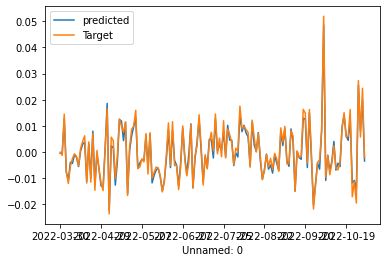

In [94]:
pd.Series(results['portfolio_returns_pred']).plot(label='predicted', legend = True)
#pd.Series(results['y_train']).plot(label='original', legend = True)
pd.Series(results['y_ammended']).plot(label='Target', legend = True)

<AxesSubplot:xlabel='Unnamed: 0'>

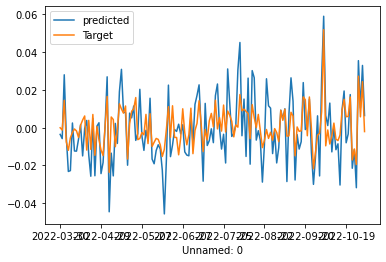

In [97]:
pd.Series(results['portfolio_returns_pred']).plot(label='predicted', legend = True)
#pd.Series(results['y_train']).plot(label='original', legend = True)
pd.Series(results['y_ammended']).plot(label='Target', legend = True)

<AxesSubplot:xlabel='Unnamed: 0'>

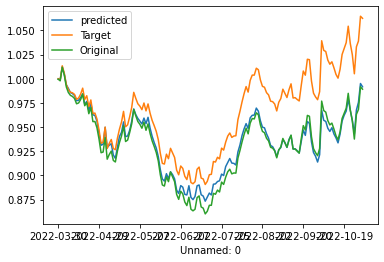

In [95]:
(pd.Series(preproc.log_to_normal_returns(results['portfolio_returns_pred'])) + 1).cumprod().plot(label='predicted', legend = True)
(pd.Series(preproc.log_to_normal_returns(results['y_ammended'])) + 1).cumprod().plot(label='Target', legend = True)
(pd.Series(preproc.log_to_normal_returns(results['y_train'])) + 1).cumprod().plot(label='Original', legend = True)


### deflated sharpe value
https://quantdare.com/deflated-sharpe-ratio-how-to-avoid-been-fooled-by-randomness/

As the mean is zero, there is no significant difference between the original return given by the risk factor from the eigenportfolio, which means the initial hyphotesis that non-lineraities seeked by a defined target are not found or present.

Next ideas: is go from step 1 of deepportfolios to harness least-communal stocks for the specific target!

is is random!

5/5 [==============================] - 0s 910us/step


<AxesSubplot:xlabel='Unnamed: 0'>

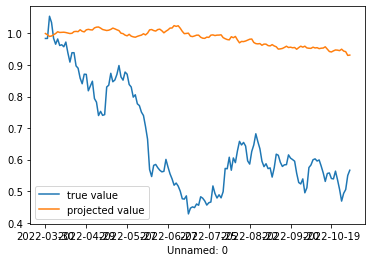

In [310]:
reconstruction = model.predict(df_returns_train)


index = 45

returns_ref = df_returns_train.iloc[:,index]
lp_ref =  pd.Series(((returns_ref + 1).cumprod()))

returns_rec = pd.Series(reconstruction[:,index])
lp_rec =  pd.Series(((returns_rec + 1).cumprod()))

lp_ref.plot(label = 'true value', legend=True)
lp_rec.plot(label = 'projected value', legend=True)

#print(np.linalg.norm((df_returns_train.iloc[:,index] - reconstruction[:,index])) )
